In [12]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [28]:
def showimg(img, text=None):
    npimg=img.numpy()
    plt.axis('off')
    if(text):
        plt.text(75,8, text, style='italic', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show();

In [23]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolder, transform=None):
        self.imageFolder=imageFolder
        self.transform=transform
    
    def __getitem__(self,index):
        img0_tuple=random.choice(self.imageFolder.imgs)
        
        get_same_class=random.randint(0,1)
        if(get_same_class):
            while True:
                img1_tuple=random.choice(self.imageFolder.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple=random.choice(self.imageFolder.imgs)
                if img0_tuple[1]!=img1_tuple[1]:
                    break
        img0=Image.open(img0_tuple[0]).convert('L') #greyscale
        img1=Image.open(img1_tuple[0]).convert('L')
        
        if self.transform is not None:
            img0=self.transform(img0)
            img1=self.transform(img1)
            
        return img0, img1, torch.from_numpy(np.array([int(img0_tuple[1]!=img1_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolder.imgs)
        

In [7]:
!curl https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0


In [43]:
import shutil
shutil.rmtree('data', ignore_errors=True)
!tar -xf "at&t.zip" -C .
#!tar -xf "at&t.zip" -C "C:\Users\tanji\Desktop\myPW\notes\siamese network"

In [24]:
folder_image=datasets.ImageFolder(root="data/faces/training/")

transformations=transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor()
])

siamese_dataset=SiameseNetworkDataset(folder_image, transformations)

In [25]:
vis_dataloader=DataLoader(siamese_dataset,
                         batch_size=8,
                         shuffle=True
                         )

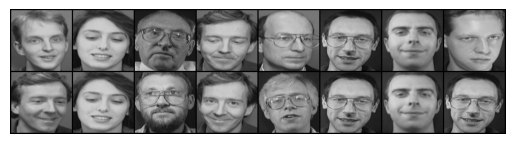

[1. 0. 1. 0. 1. 0. 0. 1.]


In [44]:
example_batch=next(iter(vis_dataloader))

concatenated=torch.cat((example_batch[0], example_batch[1]),0)

showimg(torchvision.utils.make_grid(concatenated))

print(example_batch[2].numpy().reshape(-1))

In [32]:
concatenated.shape

torch.Size([16, 1, 100, 100])

In [33]:
len(example_batch)

3

In [34]:
example_batch[0].shape

torch.Size([8, 1, 100, 100])

In [35]:
example_batch[2]

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.]])

# Better example

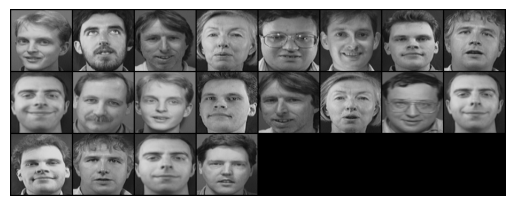

In [30]:
vis_dataloader2=DataLoader(siamese_dataset,
                         batch_size=10,
                         shuffle=True
                         )

example_batch2=next(iter(vis_dataloader2))

concatenated2=torch.cat((example_batch2[0], example_batch2[1]),0)

showimg(torchvision.utils.make_grid(concatenated2))

# Network

In [63]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__();
        
        self.cnn1=nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )
        
    def forward_once(self,x):
        output=self.cnn1(x)
        print(output.size())
        output=output.view(output.size()[0],-1)
        output=self.fc1(output)
        return output
        
    def forward(self, input1, input2):
        output1=self.forward_once(input1)
        output2=self.forward_once(input2)
        return output1, output2

In [69]:
class Contrastiveloss(nn.Module):
    def __init__(self, margin=2.0):
        super(Contrastiveloss, self).__init__()
        self.margin=margin
    
    def forward(self, output1, output2, label):
        euclidean_dist=F.pairwise_distance(output1, output2, keepdim=True)
        
        loss_contrastive=torch.mean((1-label)*torch.pow(euclidean_dist,2) + 
                                   label*torch.pow(torch.clamp(self.margin-euclidean_dist, min=0.0),2))
    #torch.clamp is a PyTorch function that clamps the elements of a tensor to be within a specified range. It takes three arguments: the input tensor, a minimum value, and a maximum value. The function replaces any elements in the input tensor that are below the minimum value with the minimum value and any elements that are above the maximum value with the maximum value.
        return loss_contrastive

In [64]:
train_dataloader=DataLoader(siamese_dataset,
                           shuffle=True,
                           batch_size=64)

In [65]:
net=SiameseNetwork()
criterion=Contrastiveloss()
optimizer=optim.Adam(net.parameters(), lr=0.0005)

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 0
 Current loss 1.8270341157913208

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 1
 Current loss 1.3973956108093262

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 2
 Current loss 0.754798173904419

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 22
 Current loss 0.3775707483291626

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 23
 Current loss 0.2727663815021515

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torc

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 43
 Current loss 0.09478674829006195

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 44
 Current loss 0.09376095980405807

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Ep

torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 64
 Current loss 0.06057220697402954

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 65
 Current loss 0.12648886442184448

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 66
 Current loss 0.08638821542263031

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.S

Epoch number 85
 Current loss 0.04925442859530449

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 86
 Current loss 0.03801325708627701

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([50, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
Epoch number 87
 Current loss 0.043528493493795395

torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.Size([64, 384, 1, 1])
torch.

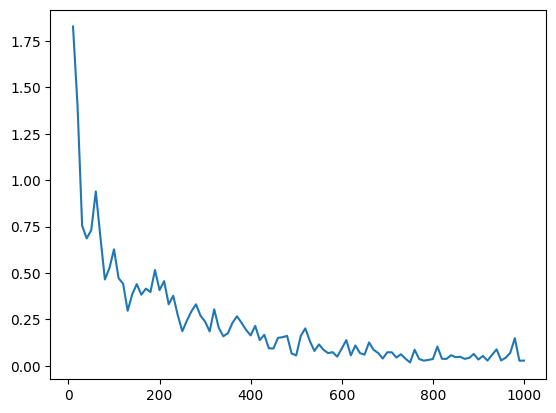

In [72]:
counter=[]
loss_history=[]
iteration=0

for epoch in range(100):
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        output1,output2=net(img0,img1)
        
        loss_contrastive=criterion(output1, output2, label)
        loss_contrastive.backward()
        
        optimizer.step()
        
        if i%10==0:
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration += 10

            counter.append(iteration)
            loss_history.append(loss_contrastive.item())
show_plot(counter, loss_history)

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


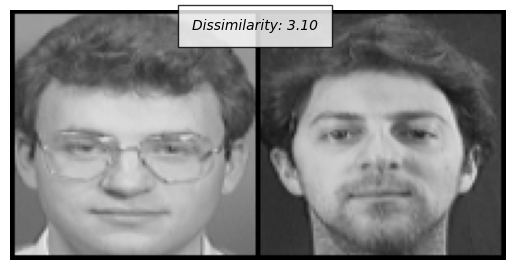

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


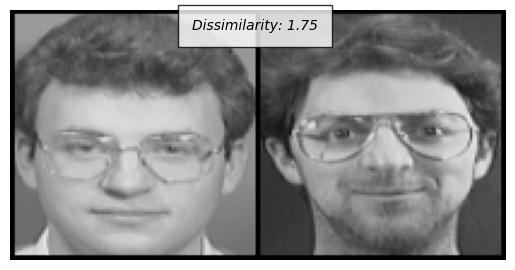

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


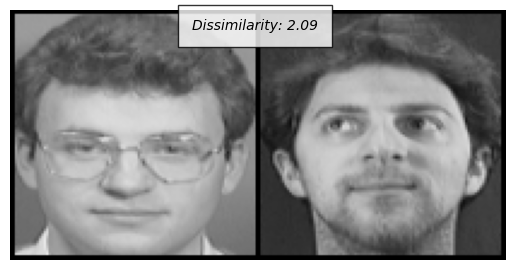

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


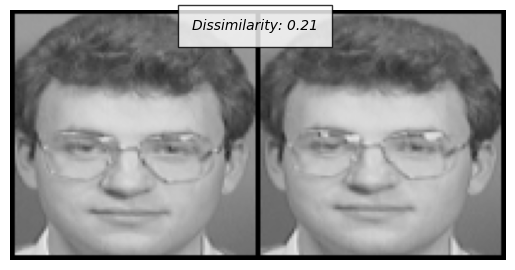

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


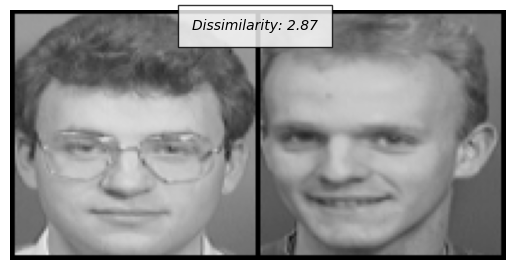

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


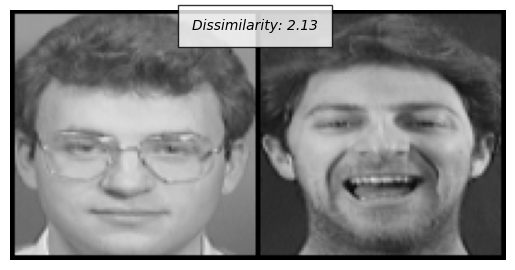

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


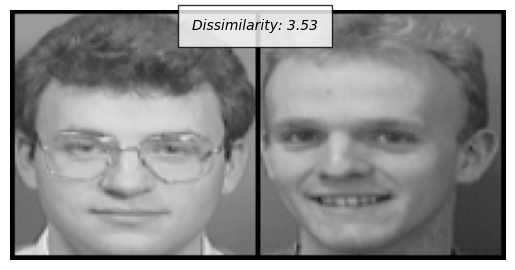

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


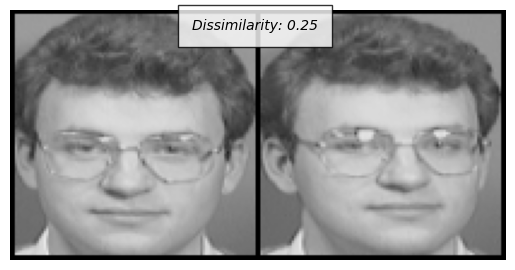

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


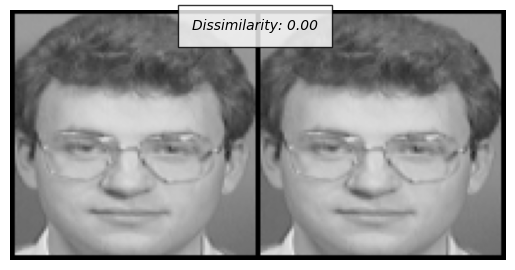

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


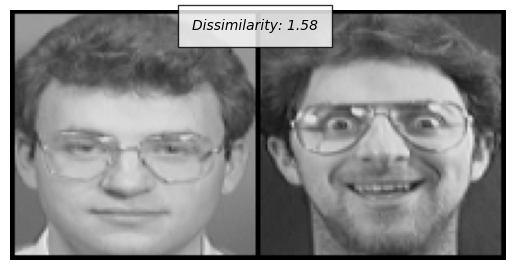

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


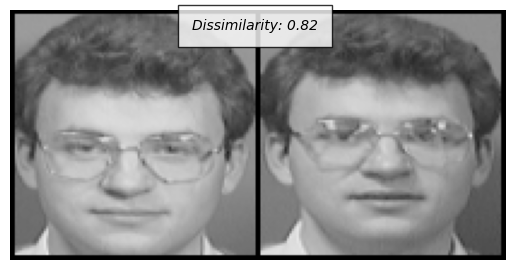

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


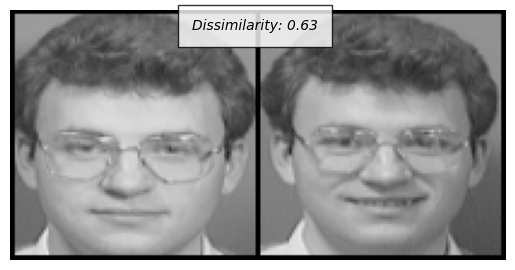

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


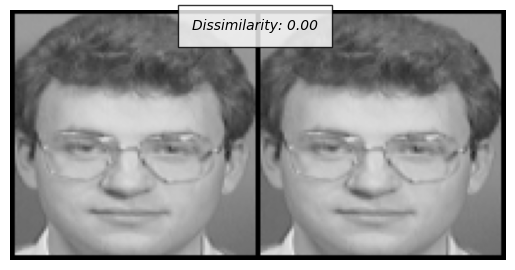

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


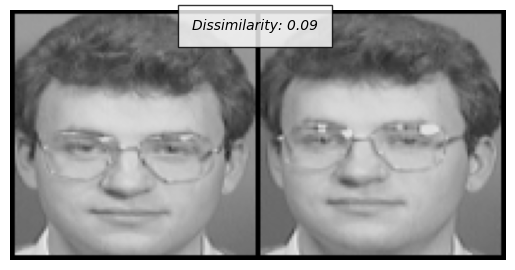

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


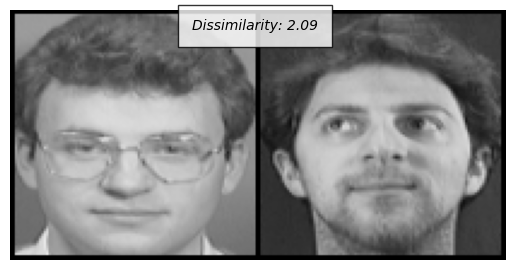

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


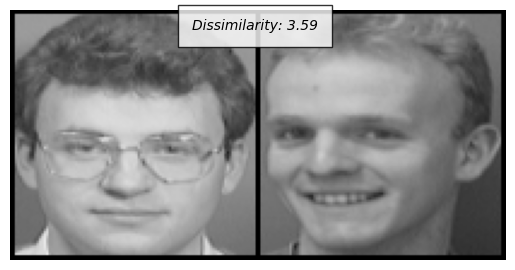

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


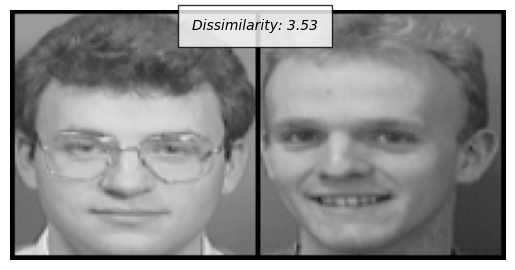

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


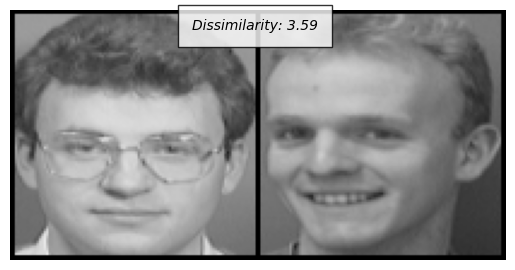

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


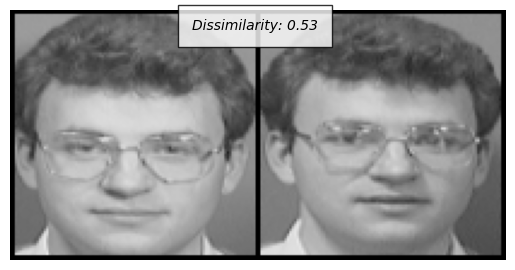

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


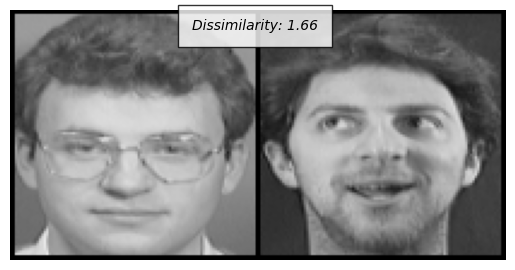

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


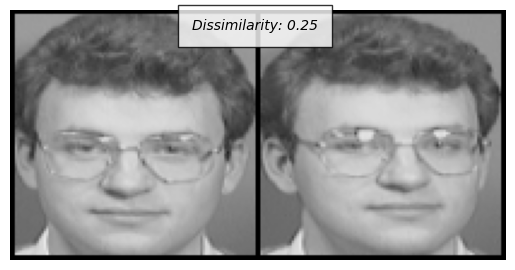

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


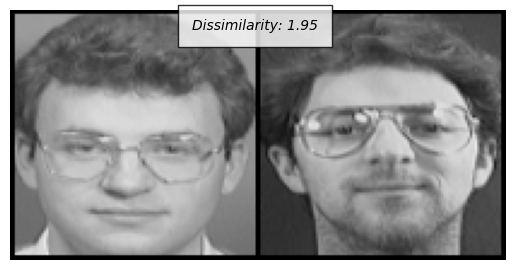

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


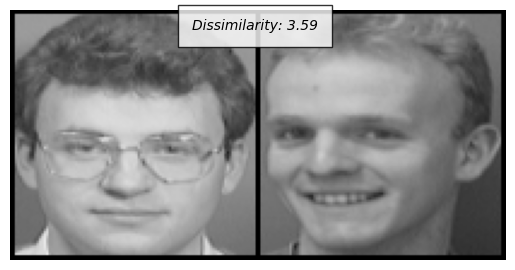

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


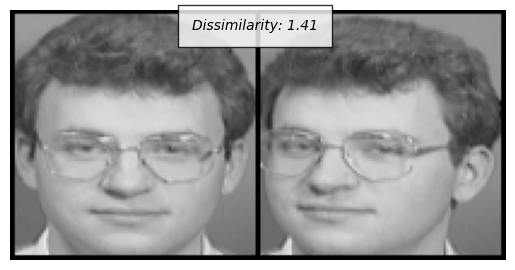

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


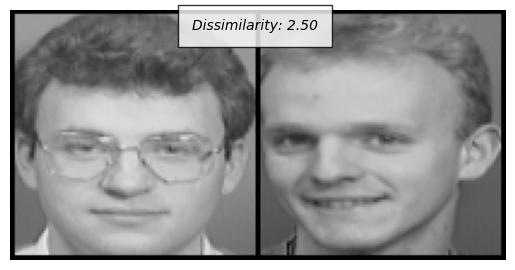

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


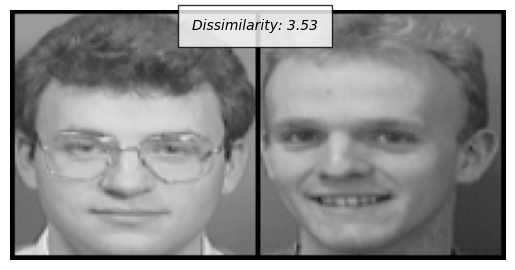

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


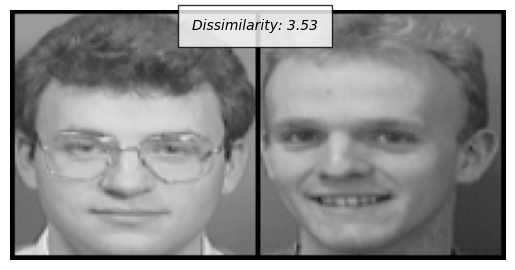

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


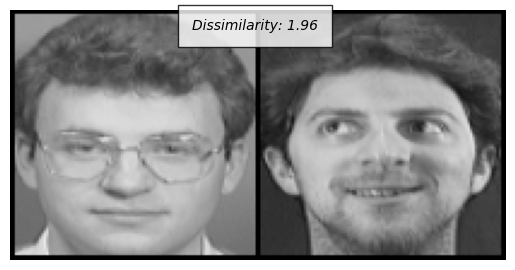

torch.Size([1, 384, 1, 1])
torch.Size([1, 384, 1, 1])


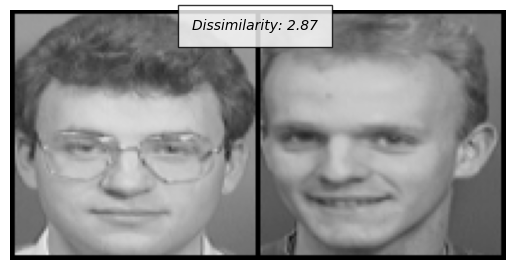

StopIteration: 

In [81]:
folder_test=datasets.ImageFolder(root='data/faces/testing/')

siamese_test_dataset=SiameseNetworkDataset(folder_test, transformations)

test_dataloader=DataLoader(siamese_test_dataset, batch_size=1, shuffle=True)

dataiter=iter(test_dataloader)
x0,_,_=next(dataiter)
for i in range(100):
    _, x1, label=next(dataiter)
    
    concatenated=torch.cat((x0,x1), 0)
    
    output1, output2 =net(x0,x1)
    
    euclidean_distance=F.pairwise_distance(output1, output2)
    showimg(torchvision.utils.make_grid(concatenated), f"Dissimilarity: {euclidean_distance.item():.2f}")